In [1]:
import numpy as np
import tensorflow as tf
import gym
import os
import datetime
from gym import wrappers


In [2]:
class theModel(tf.keras.Model):
    def __init__(self,n_states,hidden_units,n_actions):#model definition
        super(theModel,self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(n_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(i, activation = 'tanh',kernel_initializer = 'RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(n_actions, activation = 'linear', kernel_initializer = 'RandomNormal')
    @tf.function
    def call(self, inputs):#the forward pass of the neural network
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output

In [3]:
class rl_DQN:
    def __init__(self, n_states, n_actions, hidden_units, gamma,max_experiences, min_experiences, batch_size, lr):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = theModel(n_states, hidden_units, n_actions)
        self.experience = {'s': [], 'a': [], 'r' : [], 's2': [], 'done': []}#experience buffer
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))#predict the next q-value
    def get_action(self, states, epsilon):
        if np.random.random()< epsilon:
            return np.random.choice(self.n_actions)#randomly select any action
        else:
            return np.argmax(self.predict(np.atleast_2d(states))[0])#select the action with the maximum expected return
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:#don't train before a certain number of episodes
            return 0
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.experience['s'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        states_next = np.asarray([self.experience['s2'][i] for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:#calculating the loss by converting to one-hot encoding
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.math.reduce_mean(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss
    def add_experience(self, exp):#adding experience to the list until the limit is reached
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):#copying weights to the the target net
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

In [4]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):#playing the game using gym
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    losses = list()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        rewards += reward
        if done:
            reward = -200#if the it reaches the terminal state before the end of the episode
            env.reset()

        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)
        loss = TrainNet.train(TargetNet)
        if isinstance(loss, int):
            losses.append(loss)
        else:
            losses.append(loss.numpy())
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards, np.mean(losses)

In [5]:
def make_video(env, TrainNet):#recording the video
    env = wrappers.Monitor(env, os.path.join(os.getcwd(), "videos"), force=True)
    rewards = 0
    steps = 0
    done = False
    observation = env.reset()
    while not done:
        action = TrainNet.get_action(observation, 0)
        observation, reward, done, _ = env.step(action)
        steps += 1
        rewards += reward
    print("Testing steps: {} rewards {}: ".format(steps, rewards))

In [6]:
def main(a,b,c):
    env = gym.make('CartPole-v0')
    gamma = 0.99
    copy_step = 25
    num_states = len(env.observation_space.sample())
    num_actions = env.action_space.n
    hidden_units = [200, 200]
    max_experiences = 10000
    min_experiences = 100
    batch_size = 32
    lr = 1e-2
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = 'logs/dqn/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)
    TrainNet = rl_DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
    TargetNet = rl_DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
    N = 3000
    total_rewards = np.empty(N)
    epsilon = 0.6
    decay = 0.9999
    min_epsilon = 0.1
    for n in range(N):
        epsilon = max(min_epsilon, epsilon * decay)
        total_reward, losses = play_game(env, TrainNet, TargetNet, epsilon, copy_step)#playing the game
        total_rewards[n] = total_reward#updating the rewards
        avg_rewards = total_rewards[max(0, n - 100):(n + 1)].mean()#updaitng average rewards
        a.append(total_reward)
        b.append(avg_rewards)
        c.append(losses)
        with summary_writer.as_default():
            tf.summary.scalar('episode reward', total_reward, step=n)
            tf.summary.scalar('running avg reward(100)', avg_rewards, step=n)
            tf.summary.scalar('average loss)', losses, step=n)
        if n % 100 == 0:
            print("episode:", n, "episode reward:", total_reward, "eps:", epsilon, "avg reward (last 100):", avg_rewards,
                  "episode loss: ", losses)
    make_video(env, TrainNet)
    print("avg reward for last 100 episodes:", avg_rewards)
    #make_video(env, TrainNet)
    env.close()

In [7]:
total_rewards = []
average_rewards = []
losses = []
main(total_rewards,average_rewards,losses)

episode: 0 episode reward: 63.0 eps: 0.59994 avg reward (last 100): 63.0 episode loss:  0.0
episode: 100 episode reward: 97.0 eps: 0.5939702002545015 avg reward (last 100): 41.277227722772274 episode loss:  232.06715
episode: 200 episode reward: 27.0 eps: 0.5880598039643506 avg reward (last 100): 40.45544554455446 episode loss:  607.8843
episode: 300 episode reward: 11.0 eps: 0.5822082200258831 avg reward (last 100): 39.26732673267327 episode loss:  372.20715
episode: 400 episode reward: 14.0 eps: 0.5764148632173062 avg reward (last 100): 30.08910891089109 episode loss:  1555.1932
episode: 500 episode reward: 24.0 eps: 0.5706791541401719 avg reward (last 100): 29.861386138613863 episode loss:  741.0923
episode: 600 episode reward: 19.0 eps: 0.5650005191614286 avg reward (last 100): 29.861386138613863 episode loss:  252.30937
episode: 700 episode reward: 45.0 eps: 0.5593783903560536 avg reward (last 100): 26.128712871287128 episode loss:  432.2489
episode: 800 episode reward: 12.0 eps: 

Text(0.5, 1.0, 'Losses')

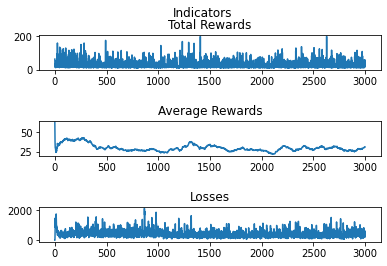

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3)
fig.tight_layout(pad=3.0)
fig.suptitle('Indicators')
axs[0].plot(total_rewards)
axs[0].set_title('Total Rewards')
axs[1].plot(average_rewards)
axs[1].set_title('Average Rewards')
axs[2].plot(losses)
axs[2].set_title('Losses')
